<a href="https://colab.research.google.com/github/amarsinghen/santander-product-recommendation/blob/master/Santander_Product_Recommendation_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
!nvidia-smi

Sat Jul  4 07:03:36 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [52]:
import matplotlib.pyplot as plt
import scipy.stats as ss
import pandas as pd
# from sklearn import preprocessing
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV
# from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, log_loss, classification_report, confusion_matrix
import gc
import gzip
from sklearn.ensemble import RandomForestClassifier
import time
import pickle
import shutil
import numpy as np
import itertools
# from cuml import RandomForestClassifier

Importing the train and test data from google drive

In [3]:
# !head -10 '/tmp/train_encoded_version.csv'

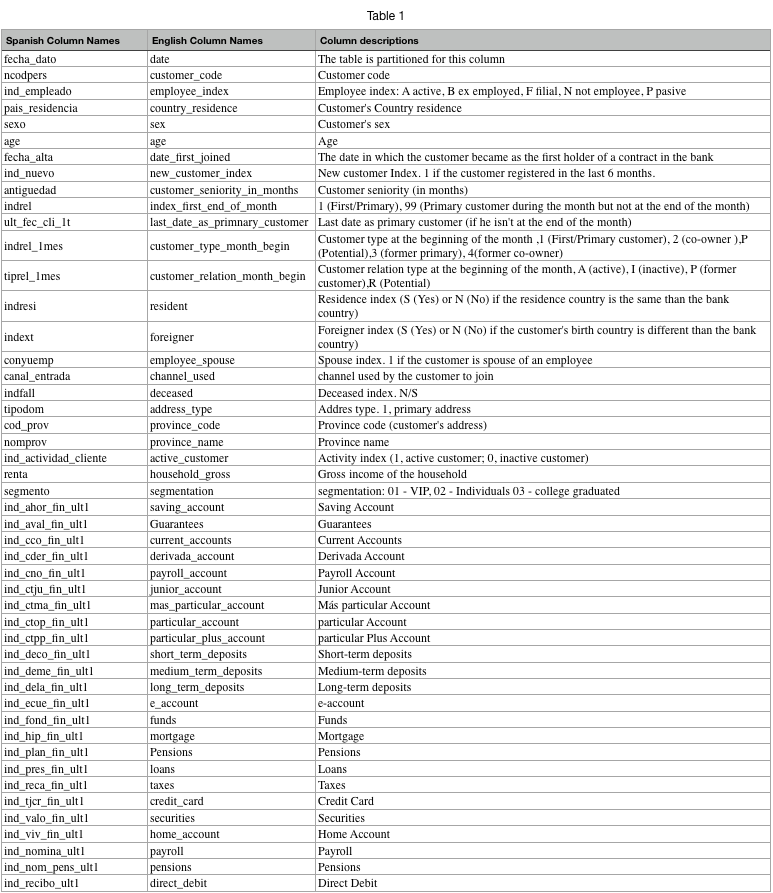

In [10]:
with gzip.open("/content/drive/My Drive/santander-product-recommendation/train_encoded_version.pkl.gz", "rb") as pickle_file:
  spr_train_encoded_df = pd.read_pickle(pickle_file)

In [11]:
spr_train_encoded_df.dtypes

date                                int8
month                               int8
total_products                      int8
customer_code                      int32
employee_index                      int8
country_residence                   int8
sex                                 int8
age                                int16
age_group                           int8
date_first_joined                  int16
new_customer_index               float32
customer_seniority_in_months       int16
index_first_end_of_month         float32
customer_type_month_begin        float32
customer_relation_month_begin       int8
resident                            int8
foreigner                           int8
channel_used                       int16
deceased                            int8
address_type                     float32
province_code                    float32
province_name                       int8
active_customer                  float32
household_gross                  float32
segmentation    

In [12]:
# spr_train_encoded_df = pd.read_csv('/tmp/train_encoded_version.csv')

In [13]:
len(spr_train_encoded_df)

13647309

In [14]:
X_columns = spr_train_encoded_df.columns.to_list()[0:25]
print(X_columns)

Y_columns = spr_train_encoded_df.columns.to_list()[25:]
print(Y_columns)

['date', 'month', 'total_products', 'customer_code', 'employee_index', 'country_residence', 'sex', 'age', 'age_group', 'date_first_joined', 'new_customer_index', 'customer_seniority_in_months', 'index_first_end_of_month', 'customer_type_month_begin', 'customer_relation_month_begin', 'resident', 'foreigner', 'channel_used', 'deceased', 'address_type', 'province_code', 'province_name', 'active_customer', 'household_gross', 'segmentation']
['saving_account', 'guarantees', 'current_accounts', 'derivada_account', 'payroll_account', 'junior_account', 'mas_particular_account', 'particular_account', 'particular_plus_account', 'short_term_deposits', 'medium_term_deposits', 'long_term_deposits', 'e_account', 'funds', 'mortgage', 'pensions_1', 'loans', 'taxes', 'credit_card', 'securities', 'home_account', 'payroll', 'pensions_2', 'direct_debit']


### XGBoost Model - X and Y columns based on Feature Importances of all features and correlation matrix

In [15]:
xgb_X_columns = ['date', 'total_products', 'customer_code', 'employee_index', 'country_residence', 'sex', 'age', 'customer_seniority_in_months', 'customer_relation_month_begin', 'resident', 'foreigner', 'channel_used', 'deceased', 'province_code', 'active_customer', 'household_gross', 'segmentation']

### RandomForest Model - X and Y columns based on Feature Importances of all features and correlation matrix

In [17]:
rfc_X_columns = ['date', 'month', 'total_products', 'customer_code', 'sex', 'age', 'customer_seniority_in_months', 'customer_relation_month_begin', 'foreigner', 'channel_used', 'province_code', 'active_customer', 'household_gross', 'segmentation']
# rfc_Y_columns = ['saving_account', 'guarantees', 'current_accounts', 'derivada_account', 'payroll_account', 'junior_account', 'mas_particular_account', 'particular_account', 'particular_plus_account', 'short_term_deposits', 'medium_term_deposits', 'long_term_deposits', 'e_account', 'funds', 'mortgage', 'pensions_1', 'loans', 'taxes', 'credit_card', 'securities', 'home_account', 'direct_debit']

### Preparing for modeling

In [18]:
X = spr_train_encoded_df[xgb_X_columns].to_numpy()
y = spr_train_encoded_df[Y_columns].to_numpy()
# X.head(2)

In [19]:
print(X.shape)
print(y.shape)

(13647309, 17)
(13647309, 24)


In [20]:
# trying to save some memory
del spr_train_encoded_df
gc.collect()

0

In [21]:
# Saving the validation set for final prediction on completely unseen data
X, X_valid, y, y_valid = train_test_split(X, y, test_size=0.02, shuffle=False)

In [22]:
# Further splitting for train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.08, shuffle=False)

In [23]:
print(X_train.shape)
print(y_train.shape)

(12304413, 17)
(12304413, 24)


Modeling with Sklearn Random Forest

In [ ]:
# start_time = time.time()
# rfc_estimator = RandomForestClassifier(n_jobs=-1)
# rfc_multilabel_model = MultiOutputClassifier(rfc_estimator)
# rfc_multilabel_model.fit(X_train, y_train)
# print("time : {}".format(time.time()-start_time))

In [ ]:
# # Trying grid search with random forest
# start_time = time.time()

# rfc_param_grid = {'estimator__max_features':[14, 10], 
#                   'estimator__n_estimators':[100, 300, 200], 
#                   'estimator__max_depth':[6, 10, 8]}

# rfc_estimator = RandomForestClassifier(n_jobs=-1)

# xgb_grid_search = GridSearchCV(estimator=MultiOutputClassifier(rfc_estimator), 
#                                param_grid=rfc_param_grid, cv=2, n_jobs=8, verbose=10)

# xgb_grid_search.fit(X_train, y_train)

# print("time : {}".format(time.time()-start_time))

Modeling with XGBoost and OneVsRestClassifier

In [ ]:
# xgb_classifier = xgb.XGBClassifier(tree_method='gpu_hist', gpu_id=0)
# clf = OneVsRestClassifier(xgb_classifier)
# clf.fit(X_train, y_train)
# y_pred = clf.predict(X_test)

Modeling with XGBoost MultiOutputClassifer

In [ ]:
# start_time = time.time()
# # create XGBoost instance with default hyper-parameters

# xgb_estimator = xgb.XGBClassifier(n_jobs=-1)

# # create MultiOutputClassifier instance with XGBoost model inside
# multilabel_model = MultiOutputClassifier(xgb_estimator)

# # fit the model
# multilabel_model.fit(X_train, y_train)

# print("time : {}".format(time.time()-start_time))

#### XGBModeling with Grid Search

In [ ]:
# MultiOutputClassifier(xgb.XGBClassifier()).get_params().keys()

dict_keys(['estimator__objective', 'estimator__base_score', 'estimator__booster', 'estimator__colsample_bylevel', 'estimator__colsample_bynode', 'estimator__colsample_bytree', 'estimator__gamma', 'estimator__gpu_id', 'estimator__importance_type', 'estimator__interaction_constraints', 'estimator__learning_rate', 'estimator__max_delta_step', 'estimator__max_depth', 'estimator__min_child_weight', 'estimator__missing', 'estimator__monotone_constraints', 'estimator__n_estimators', 'estimator__n_jobs', 'estimator__num_parallel_tree', 'estimator__random_state', 'estimator__reg_alpha', 'estimator__reg_lambda', 'estimator__scale_pos_weight', 'estimator__subsample', 'estimator__tree_method', 'estimator__validate_parameters', 'estimator__verbosity', 'estimator', 'n_jobs'])

In [ ]:
# start_time = time.time()

# xgb_param_grid = {'estimator__learning_rate':[0.3, 0.1, 0.2], 
#                   'estimator__n_estimators':[100, 10, 50], 
#                   'estimator__max_depth':[6, 2, 4]}

# xgb_estimator = xgb.XGBClassifier(n_jobs=-1, tree_method='hist', verbosity=1)

# xgb_grid_search = GridSearchCV(estimator=MultiOutputClassifier(xgb_estimator), 
#                                param_grid=xgb_param_grid, cv=2, n_jobs=2, verbose=10)

# xgb_grid_search.fit(X_train, y_train)

# print("time : {}".format(time.time()-start_time))

Fitting 2 folds for each of 27 candidates, totalling 54 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed: 21.8min
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed: 27.8min
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed: 61.5min
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed: 91.0min
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed: 133.8min
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed: 170.5min
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed: 233.5min
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed: 277.6min
[Parallel(n_jobs=2)]: Done  54 out of  54 | elapsed: 322.9min finished


time : 20863.752120256424


### XGB Classifier with one y_target at a time on GPU

In [ ]:
# accuracy_score_list = []
# log_loss_list = []
# for i in range(y_train.shape[1]):
#     print(i)
#     xgb_model = xgb.XGBClassifier(tree_method='gpu_hist', gpu_id=0, verbosity=1)
#     xgb_model.fit(X_train, y_train[:,i])
# #     with gzip.open("santander_xgb_model_06282020_yTarget{}.pkl.gz".format(i),"wb") as pickle_file:
# #         pickle.dump(xgb_model, pickle_file, protocol=pickle.HIGHEST_PROTOCOL)
#     y_pred = xgb_model.predict(X_test)
#     accuracy_score_list.append(accuracy_score(y_pred, y_test[:,i]))
#     print(y_pred.shape, y_test[:,i].shape)
#     # log_loss_list.append(log_loss(y_pred, y_test[:,i]))
    
#     # del y_pred
#     # del xgb_model

0
(1069949,) (1069949,)
1
(1069949,) (1069949,)
2


KeyboardInterrupt: ignored

In [ ]:
print(accuracy_score_list)
print(log_loss_list)

[0.9999270993290335, 0.999985046016212, 0.8965969406018418, 0.9996971818282927, 0.9603794199536614, 0.9999747651523577, 0.9902920606496197, 0.9370044740450246, 0.9713696634138637, 0.9997037241962, 0.99903640266966, 0.9718921182224574, 0.9358418018055066, 0.9861320492845921, 0.9957754995798865, 0.9930949979858853, 0.9985840446600726, 0.9602214684999004, 0.9718051981916895, 0.9798083833902363, 0.9972316437512442, 0.9816028614447978, 0.9795962237452439, 0.9473545000743026]
[]


In [ ]:
xgb.XGBClassifier().get_params().keys()

dict_keys(['base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'gamma', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'n_estimators', 'n_jobs', 'nthread', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'seed', 'silent', 'subsample', 'verbosity'])

### Grid Search - XGB CLassifier with one y_target at a time, GPU

In [ ]:
start_time = time.time()
accuracy_score_list = []
log_loss_list = []
for i in range(y_train.shape[1]):
    print(i+1, end=" ")
    xgb_param_grid = {'learning_rate':[0.1, 0.3, 0.2], 
                  'n_estimators':[100, 300, 200], 
                  'max_depth':[10, 6, 8]}
    xgb_estimator = xgb.XGBClassifier(tree_method='gpu_hist', gpu_id=0)
    xgb_grid_search_model = GridSearchCV(estimator=xgb_estimator, 
                               param_grid=xgb_param_grid, cv=2, verbose=10)
    xgb_grid_search_model.fit(X_train, y_train[:,i])
    with gzip.open("/tmp/santander_xgb_grid_search_model_07022020_yTarget{}.pkl.gz".format(i+1),"wb") as pickle_file:
        pickle.dump(xgb_grid_search_model, pickle_file, protocol=pickle.HIGHEST_PROTOCOL)
    y_pred = xgb_grid_search_model.predict(X_test)
    accuracy_score_list.append(accuracy_score(y_pred, y_test[:,i]))
    del xgb_grid_search_model
print("time : {}".format(time.time()-start_time))

1 Fitting 2 folds for each of 27 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] learning_rate=0.1, max_depth=10, n_estimators=100 ...............
[CV]  learning_rate=0.1, max_depth=10, n_estimators=100, score=0.733, total=   6.3s
[CV] learning_rate=0.1, max_depth=10, n_estimators=100 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.3s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=100, score=1.000, total=   5.7s
[CV] learning_rate=0.1, max_depth=10, n_estimators=300 ...............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.1s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=300, score=0.943, total=  11.7s
[CV] learning_rate=0.1, max_depth=10, n_estimators=300 ...............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   23.8s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=300, score=1.000, total=  12.0s
[CV] learning_rate=0.1, max_depth=10, n_estimators=200 ...............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   35.8s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=200, score=0.856, total=   8.5s
[CV] learning_rate=0.1, max_depth=10, n_estimators=200 ...............


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   44.3s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=200, score=1.000, total=   8.7s
[CV] learning_rate=0.1, max_depth=6, n_estimators=100 ................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   53.1s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=100, score=0.712, total=   5.2s
[CV] learning_rate=0.1, max_depth=6, n_estimators=100 ................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   58.3s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=100, score=1.000, total=   5.2s
[CV] learning_rate=0.1, max_depth=6, n_estimators=300 ................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.1min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=300, score=0.868, total=   9.9s
[CV] learning_rate=0.1, max_depth=6, n_estimators=300 ................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.2min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=300, score=1.000, total=   9.9s
[CV] learning_rate=0.1, max_depth=6, n_estimators=200 ................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=200, score=0.787, total=   7.5s
[CV] learning_rate=0.1, max_depth=6, n_estimators=200 ................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=200, score=1.000, total=   7.5s
[CV] learning_rate=0.1, max_depth=8, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=100, score=0.722, total=   5.4s
[CV] learning_rate=0.1, max_depth=8, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=100, score=1.000, total=   5.4s
[CV] learning_rate=0.1, max_depth=8, n_estimators=300 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=300, score=0.958, total=  11.1s
[CV] learning_rate=0.1, max_depth=8, n_estimators=300 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=300, score=1.000, total= 

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  7.6min finished


2 Fitting 2 folds for each of 27 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] learning_rate=0.1, max_depth=10, n_estimators=100 ...............
[CV]  learning_rate=0.1, max_depth=10, n_estimators=100, score=0.957, total=   5.1s
[CV] learning_rate=0.1, max_depth=10, n_estimators=100 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.1s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=100, score=1.000, total=   5.1s
[CV] learning_rate=0.1, max_depth=10, n_estimators=300 ...............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.2s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=300, score=0.984, total=   9.5s
[CV] learning_rate=0.1, max_depth=10, n_estimators=300 ...............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   19.8s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=300, score=1.000, total=   9.3s
[CV] learning_rate=0.1, max_depth=10, n_estimators=200 ...............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   29.1s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=200, score=0.982, total=   7.0s
[CV] learning_rate=0.1, max_depth=10, n_estimators=200 ...............


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   36.2s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=200, score=1.000, total=   6.9s
[CV] learning_rate=0.1, max_depth=6, n_estimators=100 ................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   43.1s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=100, score=0.969, total=   4.9s
[CV] learning_rate=0.1, max_depth=6, n_estimators=100 ................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   48.1s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=100, score=1.000, total=   4.9s
[CV] learning_rate=0.1, max_depth=6, n_estimators=300 ................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   53.0s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=300, score=0.996, total=   9.1s
[CV] learning_rate=0.1, max_depth=6, n_estimators=300 ................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.0min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=300, score=1.000, total=   9.3s
[CV] learning_rate=0.1, max_depth=6, n_estimators=200 ................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=200, score=0.988, total=   6.9s
[CV] learning_rate=0.1, max_depth=6, n_estimators=200 ................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=200, score=1.000, total=   6.9s
[CV] learning_rate=0.1, max_depth=8, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=100, score=0.974, total=   5.0s
[CV] learning_rate=0.1, max_depth=8, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=100, score=1.000, total=   5.0s
[CV] learning_rate=0.1, max_depth=8, n_estimators=300 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=300, score=0.995, total=   9.4s
[CV] learning_rate=0.1, max_depth=8, n_estimators=300 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=300, score=1.000, total= 

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  6.6min finished


3 Fitting 2 folds for each of 27 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] learning_rate=0.1, max_depth=10, n_estimators=100 ...............
[CV]  learning_rate=0.1, max_depth=10, n_estimators=100, score=0.805, total=   7.8s
[CV] learning_rate=0.1, max_depth=10, n_estimators=100 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.8s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=100, score=0.342, total=   8.2s
[CV] learning_rate=0.1, max_depth=10, n_estimators=300 ...............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   16.0s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=300, score=0.805, total=  17.6s
[CV] learning_rate=0.1, max_depth=10, n_estimators=300 ...............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   33.6s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=300, score=0.342, total=  18.2s
[CV] learning_rate=0.1, max_depth=10, n_estimators=200 ...............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   51.9s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=200, score=0.805, total=  12.7s
[CV] learning_rate=0.1, max_depth=10, n_estimators=200 ...............


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=200, score=0.342, total=  13.0s
[CV] learning_rate=0.1, max_depth=6, n_estimators=100 ................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.3min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=100, score=0.805, total=   6.1s
[CV] learning_rate=0.1, max_depth=6, n_estimators=100 ................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.4min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=100, score=0.342, total=   6.0s
[CV] learning_rate=0.1, max_depth=6, n_estimators=300 ................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.5min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=300, score=0.805, total=  11.0s
[CV] learning_rate=0.1, max_depth=6, n_estimators=300 ................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.7min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=300, score=0.342, total=  10.9s
[CV] learning_rate=0.1, max_depth=6, n_estimators=200 ................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=200, score=0.805, total=   8.6s
[CV] learning_rate=0.1, max_depth=6, n_estimators=200 ................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=200, score=0.342, total=   8.5s
[CV] learning_rate=0.1, max_depth=8, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=100, score=0.805, total=   6.7s
[CV] learning_rate=0.1, max_depth=8, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=100, score=0.342, total=   6.8s
[CV] learning_rate=0.1, max_depth=8, n_estimators=300 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=300, score=0.805, total=  13.2s
[CV] learning_rate=0.1, max_depth=8, n_estimators=300 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=300, score=0.342, total= 

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  9.7min finished


4 Fitting 2 folds for each of 27 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] learning_rate=0.1, max_depth=10, n_estimators=100 ...............
[CV]  learning_rate=0.1, max_depth=10, n_estimators=100, score=0.835, total=   6.7s
[CV] learning_rate=0.1, max_depth=10, n_estimators=100 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.7s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=100, score=1.000, total=   6.8s
[CV] learning_rate=0.1, max_depth=10, n_estimators=300 ...............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.5s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=300, score=0.872, total=  13.7s
[CV] learning_rate=0.1, max_depth=10, n_estimators=300 ...............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   27.2s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=300, score=1.000, total=  14.0s
[CV] learning_rate=0.1, max_depth=10, n_estimators=200 ...............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   41.2s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=200, score=0.854, total=  10.1s
[CV] learning_rate=0.1, max_depth=10, n_estimators=200 ...............


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   51.4s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=200, score=1.000, total=  10.6s
[CV] learning_rate=0.1, max_depth=6, n_estimators=100 ................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.0min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=100, score=0.775, total=   5.8s
[CV] learning_rate=0.1, max_depth=6, n_estimators=100 ................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.1min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=100, score=1.000, total=   5.8s
[CV] learning_rate=0.1, max_depth=6, n_estimators=300 ................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.2min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=300, score=0.791, total=  10.5s
[CV] learning_rate=0.1, max_depth=6, n_estimators=300 ................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.4min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=300, score=1.000, total=  10.7s
[CV] learning_rate=0.1, max_depth=6, n_estimators=200 ................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=200, score=0.778, total=   8.2s
[CV] learning_rate=0.1, max_depth=6, n_estimators=200 ................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=200, score=1.000, total=   8.3s
[CV] learning_rate=0.1, max_depth=8, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=100, score=0.843, total=   6.2s
[CV] learning_rate=0.1, max_depth=8, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=100, score=1.000, total=   6.2s
[CV] learning_rate=0.1, max_depth=8, n_estimators=300 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=300, score=0.854, total=  12.1s
[CV] learning_rate=0.1, max_depth=8, n_estimators=300 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=300, score=1.000, total= 

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  8.5min finished


5 Fitting 2 folds for each of 27 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] learning_rate=0.1, max_depth=10, n_estimators=100 ...............
[CV]  learning_rate=0.1, max_depth=10, n_estimators=100, score=0.358, total=   9.6s
[CV] learning_rate=0.1, max_depth=10, n_estimators=100 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.6s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=100, score=0.926, total=   9.9s
[CV] learning_rate=0.1, max_depth=10, n_estimators=300 ...............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   19.5s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=300, score=0.323, total=  19.1s
[CV] learning_rate=0.1, max_depth=10, n_estimators=300 ...............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   38.6s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=300, score=0.927, total=  19.7s
[CV] learning_rate=0.1, max_depth=10, n_estimators=200 ...............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   58.4s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=200, score=0.339, total=  14.1s
[CV] learning_rate=0.1, max_depth=10, n_estimators=200 ...............


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.2min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=200, score=0.926, total=  14.6s
[CV] learning_rate=0.1, max_depth=6, n_estimators=100 ................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.5min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=100, score=0.478, total=   6.5s
[CV] learning_rate=0.1, max_depth=6, n_estimators=100 ................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.6min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=100, score=0.928, total=   6.5s
[CV] learning_rate=0.1, max_depth=6, n_estimators=300 ................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.7min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=300, score=0.348, total=  11.2s
[CV] learning_rate=0.1, max_depth=6, n_estimators=300 ................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.9min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=300, score=0.926, total=  11.2s
[CV] learning_rate=0.1, max_depth=6, n_estimators=200 ................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=200, score=0.374, total=   8.9s
[CV] learning_rate=0.1, max_depth=6, n_estimators=200 ................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=200, score=0.927, total=   8.9s
[CV] learning_rate=0.1, max_depth=8, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=100, score=0.362, total=   7.5s
[CV] learning_rate=0.1, max_depth=8, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=100, score=0.927, total=   7.7s
[CV] learning_rate=0.1, max_depth=8, n_estimators=300 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=300, score=0.319, total=  13.9s
[CV] learning_rate=0.1, max_depth=8, n_estimators=300 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=300, score=0.927, total= 

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed: 10.2min finished


6 Fitting 2 folds for each of 27 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] learning_rate=0.1, max_depth=10, n_estimators=100 ...............
[CV]  learning_rate=0.1, max_depth=10, n_estimators=100, score=1.000, total=   5.3s
[CV] learning_rate=0.1, max_depth=10, n_estimators=100 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=100, score=1.000, total=   5.7s
[CV] learning_rate=0.1, max_depth=10, n_estimators=300 ...............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.0s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=300, score=1.000, total=  10.8s
[CV] learning_rate=0.1, max_depth=10, n_estimators=300 ...............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   21.8s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=300, score=0.999, total=  12.7s
[CV] learning_rate=0.1, max_depth=10, n_estimators=200 ...............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   34.6s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=200, score=1.000, total=   7.8s
[CV] learning_rate=0.1, max_depth=10, n_estimators=200 ...............


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   42.4s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=200, score=0.999, total=   9.0s
[CV] learning_rate=0.1, max_depth=6, n_estimators=100 ................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   51.4s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=100, score=1.000, total=   5.1s
[CV] learning_rate=0.1, max_depth=6, n_estimators=100 ................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   56.5s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=100, score=0.991, total=   5.2s
[CV] learning_rate=0.1, max_depth=6, n_estimators=300 ................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.0min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=300, score=1.000, total=   9.9s
[CV] learning_rate=0.1, max_depth=6, n_estimators=300 ................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.2min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=300, score=0.996, total=  10.1s
[CV] learning_rate=0.1, max_depth=6, n_estimators=200 ................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=200, score=1.000, total=   7.3s
[CV] learning_rate=0.1, max_depth=6, n_estimators=200 ................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=200, score=0.992, total=   7.5s
[CV] learning_rate=0.1, max_depth=8, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=100, score=1.000, total=   5.1s
[CV] learning_rate=0.1, max_depth=8, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=100, score=0.998, total=   5.4s
[CV] learning_rate=0.1, max_depth=8, n_estimators=300 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=300, score=1.000, total=  10.5s
[CV] learning_rate=0.1, max_depth=8, n_estimators=300 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=300, score=0.999, total= 

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  7.6min finished


7 Fitting 2 folds for each of 27 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] learning_rate=0.1, max_depth=10, n_estimators=100 ...............
[CV]  learning_rate=0.1, max_depth=10, n_estimators=100, score=0.573, total=   8.6s
[CV] learning_rate=0.1, max_depth=10, n_estimators=100 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.7s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=100, score=0.990, total=   8.6s
[CV] learning_rate=0.1, max_depth=10, n_estimators=300 ...............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   17.3s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=300, score=0.639, total=  18.2s
[CV] learning_rate=0.1, max_depth=10, n_estimators=300 ...............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   35.5s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=300, score=0.990, total=  18.4s
[CV] learning_rate=0.1, max_depth=10, n_estimators=200 ...............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   53.9s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=200, score=0.556, total=  12.9s
[CV] learning_rate=0.1, max_depth=10, n_estimators=200 ...............


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=200, score=0.990, total=  13.3s
[CV] learning_rate=0.1, max_depth=6, n_estimators=100 ................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.3min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=100, score=0.560, total=   6.2s
[CV] learning_rate=0.1, max_depth=6, n_estimators=100 ................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.4min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=100, score=0.990, total=   6.2s
[CV] learning_rate=0.1, max_depth=6, n_estimators=300 ................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.5min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=300, score=0.549, total=  11.2s
[CV] learning_rate=0.1, max_depth=6, n_estimators=300 ................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.7min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=300, score=0.990, total=  11.2s
[CV] learning_rate=0.1, max_depth=6, n_estimators=200 ................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=200, score=0.554, total=   8.6s
[CV] learning_rate=0.1, max_depth=6, n_estimators=200 ................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=200, score=0.990, total=   8.7s
[CV] learning_rate=0.1, max_depth=8, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=100, score=0.552, total=   7.1s
[CV] learning_rate=0.1, max_depth=8, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=100, score=0.990, total=   7.0s
[CV] learning_rate=0.1, max_depth=8, n_estimators=300 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=300, score=0.552, total=  13.5s
[CV] learning_rate=0.1, max_depth=8, n_estimators=300 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=300, score=0.990, total= 

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  9.8min finished


8 Fitting 2 folds for each of 27 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] learning_rate=0.1, max_depth=10, n_estimators=100 ...............
[CV]  learning_rate=0.1, max_depth=10, n_estimators=100, score=0.718, total=   7.3s
[CV] learning_rate=0.1, max_depth=10, n_estimators=100 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.3s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=100, score=0.865, total=   7.4s
[CV] learning_rate=0.1, max_depth=10, n_estimators=300 ...............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.7s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=300, score=0.715, total=  17.0s
[CV] learning_rate=0.1, max_depth=10, n_estimators=300 ...............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   31.7s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=300, score=0.865, total=  16.9s
[CV] learning_rate=0.1, max_depth=10, n_estimators=200 ...............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   48.7s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=200, score=0.715, total=  11.8s
[CV] learning_rate=0.1, max_depth=10, n_estimators=200 ...............


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.0min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=200, score=0.865, total=  12.1s
[CV] learning_rate=0.1, max_depth=6, n_estimators=100 ................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.2min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=100, score=0.707, total=   6.0s
[CV] learning_rate=0.1, max_depth=6, n_estimators=100 ................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.3min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=100, score=0.866, total=   6.0s
[CV] learning_rate=0.1, max_depth=6, n_estimators=300 ................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.4min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=300, score=0.707, total=  11.0s
[CV] learning_rate=0.1, max_depth=6, n_estimators=300 ................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.6min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=300, score=0.865, total=  11.0s
[CV] learning_rate=0.1, max_depth=6, n_estimators=200 ................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=200, score=0.706, total=   8.5s
[CV] learning_rate=0.1, max_depth=6, n_estimators=200 ................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=200, score=0.865, total=   8.5s
[CV] learning_rate=0.1, max_depth=8, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=100, score=0.715, total=   6.4s
[CV] learning_rate=0.1, max_depth=8, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=100, score=0.866, total=   6.4s
[CV] learning_rate=0.1, max_depth=8, n_estimators=300 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=300, score=0.713, total=  12.9s
[CV] learning_rate=0.1, max_depth=8, n_estimators=300 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=300, score=0.865, total= 

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  9.5min finished


9 Fitting 2 folds for each of 27 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] learning_rate=0.1, max_depth=10, n_estimators=100 ...............
[CV]  learning_rate=0.1, max_depth=10, n_estimators=100, score=0.611, total=   7.0s
[CV] learning_rate=0.1, max_depth=10, n_estimators=100 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.0s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=100, score=0.955, total=   7.2s
[CV] learning_rate=0.1, max_depth=10, n_estimators=300 ...............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.2s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=300, score=0.616, total=  16.1s
[CV] learning_rate=0.1, max_depth=10, n_estimators=300 ...............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   30.3s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=300, score=0.955, total=  16.2s
[CV] learning_rate=0.1, max_depth=10, n_estimators=200 ...............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   46.6s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=200, score=0.614, total=  11.0s
[CV] learning_rate=0.1, max_depth=10, n_estimators=200 ...............


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   57.6s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=200, score=0.955, total=  11.4s
[CV] learning_rate=0.1, max_depth=6, n_estimators=100 ................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.2min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=100, score=0.605, total=   5.9s
[CV] learning_rate=0.1, max_depth=6, n_estimators=100 ................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.2min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=100, score=0.955, total=   5.9s
[CV] learning_rate=0.1, max_depth=6, n_estimators=300 ................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.3min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=300, score=0.611, total=  10.7s
[CV] learning_rate=0.1, max_depth=6, n_estimators=300 ................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.5min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=300, score=0.955, total=  10.7s
[CV] learning_rate=0.1, max_depth=6, n_estimators=200 ................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=200, score=0.611, total=   8.3s
[CV] learning_rate=0.1, max_depth=6, n_estimators=200 ................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=200, score=0.955, total=   8.4s
[CV] learning_rate=0.1, max_depth=8, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=100, score=0.606, total=   6.3s
[CV] learning_rate=0.1, max_depth=8, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=100, score=0.955, total=   6.4s
[CV] learning_rate=0.1, max_depth=8, n_estimators=300 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=300, score=0.612, total=  12.7s
[CV] learning_rate=0.1, max_depth=8, n_estimators=300 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=300, score=0.955, total= 

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  9.3min finished


10 Fitting 2 folds for each of 27 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] learning_rate=0.1, max_depth=10, n_estimators=100 ...............
[CV]  learning_rate=0.1, max_depth=10, n_estimators=100, score=0.257, total=   7.2s
[CV] learning_rate=0.1, max_depth=10, n_estimators=100 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.2s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=100, score=0.998, total=   7.5s
[CV] learning_rate=0.1, max_depth=10, n_estimators=300 ...............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.7s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=300, score=0.338, total=  15.1s
[CV] learning_rate=0.1, max_depth=10, n_estimators=300 ...............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   29.8s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=300, score=0.998, total=  15.2s
[CV] learning_rate=0.1, max_depth=10, n_estimators=200 ...............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   45.0s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=200, score=0.255, total=  10.9s
[CV] learning_rate=0.1, max_depth=10, n_estimators=200 ...............


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   56.0s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=200, score=0.998, total=  11.0s
[CV] learning_rate=0.1, max_depth=6, n_estimators=100 ................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.1min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=100, score=0.241, total=   5.8s
[CV] learning_rate=0.1, max_depth=6, n_estimators=100 ................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.2min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=100, score=0.998, total=   5.7s
[CV] learning_rate=0.1, max_depth=6, n_estimators=300 ................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.3min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=300, score=0.219, total=  10.5s
[CV] learning_rate=0.1, max_depth=6, n_estimators=300 ................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.5min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=300, score=0.998, total=  10.4s
[CV] learning_rate=0.1, max_depth=6, n_estimators=200 ................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=200, score=0.240, total=   8.1s
[CV] learning_rate=0.1, max_depth=6, n_estimators=200 ................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=200, score=0.998, total=   8.0s
[CV] learning_rate=0.1, max_depth=8, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=100, score=0.245, total=   6.4s
[CV] learning_rate=0.1, max_depth=8, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=100, score=0.998, total=   6.4s
[CV] learning_rate=0.1, max_depth=8, n_estimators=300 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=300, score=0.265, total=  12.4s
[CV] learning_rate=0.1, max_depth=8, n_estimators=300 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=300, score=0.998, total= 

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  8.9min finished


11 Fitting 2 folds for each of 27 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] learning_rate=0.1, max_depth=10, n_estimators=100 ...............
[CV]  learning_rate=0.1, max_depth=10, n_estimators=100, score=0.679, total=   7.0s
[CV] learning_rate=0.1, max_depth=10, n_estimators=100 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.0s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=100, score=0.998, total=   7.1s
[CV] learning_rate=0.1, max_depth=10, n_estimators=300 ...............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.1s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=300, score=0.708, total=  14.9s
[CV] learning_rate=0.1, max_depth=10, n_estimators=300 ...............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   29.0s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=300, score=0.998, total=  15.3s
[CV] learning_rate=0.1, max_depth=10, n_estimators=200 ...............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   44.3s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=200, score=0.699, total=  10.9s
[CV] learning_rate=0.1, max_depth=10, n_estimators=200 ...............


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   55.2s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=200, score=0.998, total=  11.1s
[CV] learning_rate=0.1, max_depth=6, n_estimators=100 ................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.1min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=100, score=0.642, total=   5.8s
[CV] learning_rate=0.1, max_depth=6, n_estimators=100 ................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.2min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=100, score=0.998, total=   5.8s
[CV] learning_rate=0.1, max_depth=6, n_estimators=300 ................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.3min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=300, score=0.653, total=  10.5s
[CV] learning_rate=0.1, max_depth=6, n_estimators=300 ................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.5min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=300, score=0.998, total=  10.5s
[CV] learning_rate=0.1, max_depth=6, n_estimators=200 ................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=200, score=0.648, total=   8.1s
[CV] learning_rate=0.1, max_depth=6, n_estimators=200 ................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=200, score=0.998, total=   8.2s
[CV] learning_rate=0.1, max_depth=8, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=100, score=0.677, total=   6.2s
[CV] learning_rate=0.1, max_depth=8, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=100, score=0.998, total=   6.4s
[CV] learning_rate=0.1, max_depth=8, n_estimators=300 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=300, score=0.691, total=  12.2s
[CV] learning_rate=0.1, max_depth=8, n_estimators=300 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=300, score=0.998, total= 

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  8.8min finished


12 Fitting 2 folds for each of 27 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] learning_rate=0.1, max_depth=10, n_estimators=100 ...............
[CV]  learning_rate=0.1, max_depth=10, n_estimators=100, score=0.670, total=   8.1s
[CV] learning_rate=0.1, max_depth=10, n_estimators=100 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.1s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=100, score=0.955, total=   8.5s
[CV] learning_rate=0.1, max_depth=10, n_estimators=300 ...............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   16.6s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=300, score=0.664, total=  17.4s
[CV] learning_rate=0.1, max_depth=10, n_estimators=300 ...............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   34.0s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=300, score=0.955, total=  18.5s
[CV] learning_rate=0.1, max_depth=10, n_estimators=200 ...............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   52.6s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=200, score=0.665, total=  12.8s
[CV] learning_rate=0.1, max_depth=10, n_estimators=200 ...............


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=200, score=0.955, total=  13.3s
[CV] learning_rate=0.1, max_depth=6, n_estimators=100 ................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.3min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=100, score=0.683, total=   6.0s
[CV] learning_rate=0.1, max_depth=6, n_estimators=100 ................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.4min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=100, score=0.955, total=   6.3s
[CV] learning_rate=0.1, max_depth=6, n_estimators=300 ................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.5min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=300, score=0.663, total=  10.8s
[CV] learning_rate=0.1, max_depth=6, n_estimators=300 ................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.7min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=300, score=0.955, total=  11.1s
[CV] learning_rate=0.1, max_depth=6, n_estimators=200 ................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=200, score=0.666, total=   8.5s
[CV] learning_rate=0.1, max_depth=6, n_estimators=200 ................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=200, score=0.955, total=   8.8s
[CV] learning_rate=0.1, max_depth=8, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=100, score=0.675, total=   6.7s
[CV] learning_rate=0.1, max_depth=8, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=100, score=0.955, total=   7.1s
[CV] learning_rate=0.1, max_depth=8, n_estimators=300 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=300, score=0.669, total=  13.0s
[CV] learning_rate=0.1, max_depth=8, n_estimators=300 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=300, score=0.955, total= 

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  9.7min finished


13 Fitting 2 folds for each of 27 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] learning_rate=0.1, max_depth=10, n_estimators=100 ...............
[CV]  learning_rate=0.1, max_depth=10, n_estimators=100, score=0.542, total=   9.1s
[CV] learning_rate=0.1, max_depth=10, n_estimators=100 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.1s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=100, score=0.919, total=   9.0s
[CV] learning_rate=0.1, max_depth=10, n_estimators=300 ...............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   18.1s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=300, score=0.533, total=  18.6s
[CV] learning_rate=0.1, max_depth=10, n_estimators=300 ...............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   36.8s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=300, score=0.920, total=  19.0s
[CV] learning_rate=0.1, max_depth=10, n_estimators=200 ...............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   55.8s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=200, score=0.531, total=  13.8s
[CV] learning_rate=0.1, max_depth=10, n_estimators=200 ...............


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.2min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=200, score=0.920, total=  13.8s
[CV] learning_rate=0.1, max_depth=6, n_estimators=100 ................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.4min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=100, score=0.556, total=   6.3s
[CV] learning_rate=0.1, max_depth=6, n_estimators=100 ................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.5min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=100, score=0.918, total=   6.2s
[CV] learning_rate=0.1, max_depth=6, n_estimators=300 ................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.6min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=300, score=0.536, total=  11.1s
[CV] learning_rate=0.1, max_depth=6, n_estimators=300 ................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.8min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=300, score=0.919, total=  11.0s
[CV] learning_rate=0.1, max_depth=6, n_estimators=200 ................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=200, score=0.547, total=   8.7s
[CV] learning_rate=0.1, max_depth=6, n_estimators=200 ................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=200, score=0.919, total=   8.6s
[CV] learning_rate=0.1, max_depth=8, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=100, score=0.543, total=   7.2s
[CV] learning_rate=0.1, max_depth=8, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=100, score=0.919, total=   7.2s
[CV] learning_rate=0.1, max_depth=8, n_estimators=300 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=300, score=0.493, total=  13.8s
[CV] learning_rate=0.1, max_depth=8, n_estimators=300 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=300, score=0.919, total= 

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed: 10.0min finished


14 Fitting 2 folds for each of 27 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] learning_rate=0.1, max_depth=10, n_estimators=100 ...............
[CV]  learning_rate=0.1, max_depth=10, n_estimators=100, score=0.693, total=   8.0s
[CV] learning_rate=0.1, max_depth=10, n_estimators=100 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.0s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=100, score=0.981, total=   8.1s
[CV] learning_rate=0.1, max_depth=10, n_estimators=300 ...............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   16.2s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=300, score=0.692, total=  17.2s
[CV] learning_rate=0.1, max_depth=10, n_estimators=300 ...............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   33.4s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=300, score=0.981, total=  17.4s
[CV] learning_rate=0.1, max_depth=10, n_estimators=200 ...............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   50.8s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=200, score=0.694, total=  12.5s
[CV] learning_rate=0.1, max_depth=10, n_estimators=200 ...............


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=200, score=0.981, total=  12.8s
[CV] learning_rate=0.1, max_depth=6, n_estimators=100 ................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.3min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=100, score=0.694, total=   6.1s
[CV] learning_rate=0.1, max_depth=6, n_estimators=100 ................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.4min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=100, score=0.981, total=   6.1s
[CV] learning_rate=0.1, max_depth=6, n_estimators=300 ................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.5min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=300, score=0.693, total=  10.9s
[CV] learning_rate=0.1, max_depth=6, n_estimators=300 ................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.7min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=300, score=0.981, total=  10.9s
[CV] learning_rate=0.1, max_depth=6, n_estimators=200 ................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=200, score=0.696, total=   8.5s
[CV] learning_rate=0.1, max_depth=6, n_estimators=200 ................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=200, score=0.981, total=   8.5s
[CV] learning_rate=0.1, max_depth=8, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=100, score=0.689, total=   6.8s
[CV] learning_rate=0.1, max_depth=8, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=100, score=0.981, total=   6.9s
[CV] learning_rate=0.1, max_depth=8, n_estimators=300 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=300, score=0.692, total=  13.1s
[CV] learning_rate=0.1, max_depth=8, n_estimators=300 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=300, score=0.981, total= 

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  9.6min finished


15 Fitting 2 folds for each of 27 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] learning_rate=0.1, max_depth=10, n_estimators=100 ...............
[CV]  learning_rate=0.1, max_depth=10, n_estimators=100, score=0.763, total=   7.4s
[CV] learning_rate=0.1, max_depth=10, n_estimators=100 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.4s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=100, score=0.994, total=   7.7s
[CV] learning_rate=0.1, max_depth=10, n_estimators=300 ...............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.2s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=300, score=0.787, total=  16.2s
[CV] learning_rate=0.1, max_depth=10, n_estimators=300 ...............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   31.4s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=300, score=0.994, total=  16.6s
[CV] learning_rate=0.1, max_depth=10, n_estimators=200 ...............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   48.1s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=200, score=0.785, total=  11.6s
[CV] learning_rate=0.1, max_depth=10, n_estimators=200 ...............


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   59.6s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=200, score=0.994, total=  12.1s
[CV] learning_rate=0.1, max_depth=6, n_estimators=100 ................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.2min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=100, score=0.738, total=   5.9s
[CV] learning_rate=0.1, max_depth=6, n_estimators=100 ................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.3min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=100, score=0.994, total=   6.1s
[CV] learning_rate=0.1, max_depth=6, n_estimators=300 ................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.4min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=300, score=0.725, total=  10.9s
[CV] learning_rate=0.1, max_depth=6, n_estimators=300 ................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.6min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=300, score=0.994, total=  11.0s
[CV] learning_rate=0.1, max_depth=6, n_estimators=200 ................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=200, score=0.719, total=   8.4s
[CV] learning_rate=0.1, max_depth=6, n_estimators=200 ................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=200, score=0.994, total=   8.6s
[CV] learning_rate=0.1, max_depth=8, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=100, score=0.736, total=   6.5s
[CV] learning_rate=0.1, max_depth=8, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=100, score=0.994, total=   6.7s
[CV] learning_rate=0.1, max_depth=8, n_estimators=300 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=300, score=0.760, total=  12.9s
[CV] learning_rate=0.1, max_depth=8, n_estimators=300 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=300, score=0.994, total= 

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  9.3min finished


16 Fitting 2 folds for each of 27 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] learning_rate=0.1, max_depth=10, n_estimators=100 ...............
[CV]  learning_rate=0.1, max_depth=10, n_estimators=100, score=0.701, total=   7.9s
[CV] learning_rate=0.1, max_depth=10, n_estimators=100 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.9s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=100, score=0.990, total=   7.8s
[CV] learning_rate=0.1, max_depth=10, n_estimators=300 ...............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.7s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=300, score=0.710, total=  16.8s
[CV] learning_rate=0.1, max_depth=10, n_estimators=300 ...............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   32.6s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=300, score=0.990, total=  16.3s
[CV] learning_rate=0.1, max_depth=10, n_estimators=200 ...............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   48.9s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=200, score=0.700, total=  12.0s
[CV] learning_rate=0.1, max_depth=10, n_estimators=200 ...............


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.0min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=200, score=0.990, total=  12.0s
[CV] learning_rate=0.1, max_depth=6, n_estimators=100 ................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.2min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=100, score=0.696, total=   6.0s
[CV] learning_rate=0.1, max_depth=6, n_estimators=100 ................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.3min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=100, score=0.990, total=   6.1s
[CV] learning_rate=0.1, max_depth=6, n_estimators=300 ................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.4min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=300, score=0.681, total=  10.7s
[CV] learning_rate=0.1, max_depth=6, n_estimators=300 ................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.6min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=300, score=0.990, total=  10.7s
[CV] learning_rate=0.1, max_depth=6, n_estimators=200 ................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=200, score=0.679, total=   8.4s
[CV] learning_rate=0.1, max_depth=6, n_estimators=200 ................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=200, score=0.990, total=   8.4s
[CV] learning_rate=0.1, max_depth=8, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=100, score=0.701, total=   6.7s
[CV] learning_rate=0.1, max_depth=8, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=100, score=0.990, total=   6.7s
[CV] learning_rate=0.1, max_depth=8, n_estimators=300 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=300, score=0.694, total=  12.9s
[CV] learning_rate=0.1, max_depth=8, n_estimators=300 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=300, score=0.990, total= 

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  9.4min finished


17 Fitting 2 folds for each of 27 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] learning_rate=0.1, max_depth=10, n_estimators=100 ...............
[CV]  learning_rate=0.1, max_depth=10, n_estimators=100, score=0.698, total=   6.9s
[CV] learning_rate=0.1, max_depth=10, n_estimators=100 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.9s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=100, score=0.997, total=   7.3s
[CV] learning_rate=0.1, max_depth=10, n_estimators=300 ...............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.3s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=300, score=0.717, total=  14.9s
[CV] learning_rate=0.1, max_depth=10, n_estimators=300 ...............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   29.1s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=300, score=0.997, total=  15.6s
[CV] learning_rate=0.1, max_depth=10, n_estimators=200 ...............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   44.8s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=200, score=0.712, total=  10.8s
[CV] learning_rate=0.1, max_depth=10, n_estimators=200 ...............


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   55.6s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=200, score=0.997, total=  11.4s
[CV] learning_rate=0.1, max_depth=6, n_estimators=100 ................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.1min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=100, score=0.645, total=   5.8s
[CV] learning_rate=0.1, max_depth=6, n_estimators=100 ................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.2min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=100, score=0.997, total=   6.0s
[CV] learning_rate=0.1, max_depth=6, n_estimators=300 ................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.3min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=300, score=0.652, total=  10.6s
[CV] learning_rate=0.1, max_depth=6, n_estimators=300 ................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.5min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=300, score=0.997, total=  10.9s
[CV] learning_rate=0.1, max_depth=6, n_estimators=200 ................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=200, score=0.639, total=   8.2s
[CV] learning_rate=0.1, max_depth=6, n_estimators=200 ................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=200, score=0.997, total=   8.5s
[CV] learning_rate=0.1, max_depth=8, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=100, score=0.678, total=   6.3s
[CV] learning_rate=0.1, max_depth=8, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=100, score=0.997, total=   6.5s
[CV] learning_rate=0.1, max_depth=8, n_estimators=300 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=300, score=0.689, total=  12.3s
[CV] learning_rate=0.1, max_depth=8, n_estimators=300 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=300, score=0.997, total= 

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  8.9min finished


18 Fitting 2 folds for each of 27 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] learning_rate=0.1, max_depth=10, n_estimators=100 ...............
[CV]  learning_rate=0.1, max_depth=10, n_estimators=100, score=0.365, total=   9.4s
[CV] learning_rate=0.1, max_depth=10, n_estimators=100 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.4s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=100, score=0.948, total=   9.7s
[CV] learning_rate=0.1, max_depth=10, n_estimators=300 ...............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   19.2s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=300, score=0.356, total=  19.1s
[CV] learning_rate=0.1, max_depth=10, n_estimators=300 ...............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   38.3s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=300, score=0.949, total=  19.6s
[CV] learning_rate=0.1, max_depth=10, n_estimators=200 ...............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   57.9s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=200, score=0.355, total=  14.0s
[CV] learning_rate=0.1, max_depth=10, n_estimators=200 ...............


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.2min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=200, score=0.948, total=  14.6s
[CV] learning_rate=0.1, max_depth=6, n_estimators=100 ................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.4min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=100, score=0.416, total=   6.3s
[CV] learning_rate=0.1, max_depth=6, n_estimators=100 ................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.5min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=100, score=0.947, total=   6.3s
[CV] learning_rate=0.1, max_depth=6, n_estimators=300 ................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.7min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=300, score=0.336, total=  11.2s
[CV] learning_rate=0.1, max_depth=6, n_estimators=300 ................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.8min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=300, score=0.948, total=  11.3s
[CV] learning_rate=0.1, max_depth=6, n_estimators=200 ................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=200, score=0.338, total=   8.9s
[CV] learning_rate=0.1, max_depth=6, n_estimators=200 ................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=200, score=0.947, total=   8.8s
[CV] learning_rate=0.1, max_depth=8, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=100, score=0.363, total=   7.3s
[CV] learning_rate=0.1, max_depth=8, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=100, score=0.947, total=   7.5s
[CV] learning_rate=0.1, max_depth=8, n_estimators=300 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=300, score=0.317, total=  13.7s
[CV] learning_rate=0.1, max_depth=8, n_estimators=300 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=300, score=0.948, total= 

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed: 10.2min finished


19 Fitting 2 folds for each of 27 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] learning_rate=0.1, max_depth=10, n_estimators=100 ...............
[CV]  learning_rate=0.1, max_depth=10, n_estimators=100, score=0.540, total=   8.3s
[CV] learning_rate=0.1, max_depth=10, n_estimators=100 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.3s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=100, score=0.954, total=   8.3s
[CV] learning_rate=0.1, max_depth=10, n_estimators=300 ...............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   16.6s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=300, score=0.534, total=  17.8s
[CV] learning_rate=0.1, max_depth=10, n_estimators=300 ...............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   34.4s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=300, score=0.954, total=  18.0s
[CV] learning_rate=0.1, max_depth=10, n_estimators=200 ...............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   52.5s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=200, score=0.533, total=  12.9s
[CV] learning_rate=0.1, max_depth=10, n_estimators=200 ...............


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=200, score=0.954, total=  13.1s
[CV] learning_rate=0.1, max_depth=6, n_estimators=100 ................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.3min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=100, score=0.607, total=   6.1s
[CV] learning_rate=0.1, max_depth=6, n_estimators=100 ................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.4min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=100, score=0.954, total=   6.2s
[CV] learning_rate=0.1, max_depth=6, n_estimators=300 ................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.5min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=300, score=0.530, total=  10.8s
[CV] learning_rate=0.1, max_depth=6, n_estimators=300 ................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.7min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=300, score=0.954, total=  11.1s
[CV] learning_rate=0.1, max_depth=6, n_estimators=200 ................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=200, score=0.527, total=   8.5s
[CV] learning_rate=0.1, max_depth=6, n_estimators=200 ................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=200, score=0.954, total=   8.6s
[CV] learning_rate=0.1, max_depth=8, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=100, score=0.543, total=   6.8s
[CV] learning_rate=0.1, max_depth=8, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=100, score=0.954, total=   7.0s
[CV] learning_rate=0.1, max_depth=8, n_estimators=300 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=300, score=0.524, total=  13.2s
[CV] learning_rate=0.1, max_depth=8, n_estimators=300 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=300, score=0.954, total= 

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  9.7min finished


20 Fitting 2 folds for each of 27 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] learning_rate=0.1, max_depth=10, n_estimators=100 ...............
[CV]  learning_rate=0.1, max_depth=10, n_estimators=100, score=0.681, total=   8.0s
[CV] learning_rate=0.1, max_depth=10, n_estimators=100 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.0s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=100, score=0.974, total=   8.5s
[CV] learning_rate=0.1, max_depth=10, n_estimators=300 ...............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   16.6s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=300, score=0.675, total=  17.3s
[CV] learning_rate=0.1, max_depth=10, n_estimators=300 ...............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   33.9s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=300, score=0.974, total=  17.9s
[CV] learning_rate=0.1, max_depth=10, n_estimators=200 ...............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   51.8s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=200, score=0.678, total=  12.4s
[CV] learning_rate=0.1, max_depth=10, n_estimators=200 ...............


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=200, score=0.974, total=  13.1s
[CV] learning_rate=0.1, max_depth=6, n_estimators=100 ................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.3min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=100, score=0.675, total=   6.0s
[CV] learning_rate=0.1, max_depth=6, n_estimators=100 ................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.4min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=100, score=0.973, total=   6.2s
[CV] learning_rate=0.1, max_depth=6, n_estimators=300 ................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.5min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=300, score=0.664, total=  10.9s
[CV] learning_rate=0.1, max_depth=6, n_estimators=300 ................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.7min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=300, score=0.974, total=  11.0s
[CV] learning_rate=0.1, max_depth=6, n_estimators=200 ................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=200, score=0.666, total=   8.5s
[CV] learning_rate=0.1, max_depth=6, n_estimators=200 ................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=200, score=0.974, total=   8.6s
[CV] learning_rate=0.1, max_depth=8, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=100, score=0.679, total=   6.8s
[CV] learning_rate=0.1, max_depth=8, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=100, score=0.974, total=   7.1s
[CV] learning_rate=0.1, max_depth=8, n_estimators=300 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=300, score=0.674, total=  13.2s
[CV] learning_rate=0.1, max_depth=8, n_estimators=300 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=300, score=0.974, total= 

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  9.7min finished


21 Fitting 2 folds for each of 27 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] learning_rate=0.1, max_depth=10, n_estimators=100 ...............
[CV]  learning_rate=0.1, max_depth=10, n_estimators=100, score=0.609, total=   7.5s
[CV] learning_rate=0.1, max_depth=10, n_estimators=100 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.5s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=100, score=0.996, total=   7.7s
[CV] learning_rate=0.1, max_depth=10, n_estimators=300 ...............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.2s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=300, score=0.646, total=  16.1s
[CV] learning_rate=0.1, max_depth=10, n_estimators=300 ...............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   31.4s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=300, score=0.996, total=  16.5s
[CV] learning_rate=0.1, max_depth=10, n_estimators=200 ...............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   47.9s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=200, score=0.628, total=  11.7s
[CV] learning_rate=0.1, max_depth=10, n_estimators=200 ...............


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   59.6s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=200, score=0.996, total=  11.9s
[CV] learning_rate=0.1, max_depth=6, n_estimators=100 ................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.2min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=100, score=0.588, total=   6.0s
[CV] learning_rate=0.1, max_depth=6, n_estimators=100 ................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.3min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=100, score=0.996, total=   6.0s
[CV] learning_rate=0.1, max_depth=6, n_estimators=300 ................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.4min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=300, score=0.591, total=  10.8s
[CV] learning_rate=0.1, max_depth=6, n_estimators=300 ................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.6min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=300, score=0.996, total=  10.9s
[CV] learning_rate=0.1, max_depth=6, n_estimators=200 ................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=200, score=0.589, total=   8.4s
[CV] learning_rate=0.1, max_depth=6, n_estimators=200 ................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=200, score=0.996, total=   8.4s
[CV] learning_rate=0.1, max_depth=8, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=100, score=0.588, total=   6.5s
[CV] learning_rate=0.1, max_depth=8, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=100, score=0.996, total=   6.7s
[CV] learning_rate=0.1, max_depth=8, n_estimators=300 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=300, score=0.604, total=  12.9s
[CV] learning_rate=0.1, max_depth=8, n_estimators=300 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=300, score=0.996, total= 

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  9.3min finished


22 Fitting 2 folds for each of 27 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] learning_rate=0.1, max_depth=10, n_estimators=100 ...............
[CV]  learning_rate=0.1, max_depth=10, n_estimators=100, score=0.808, total=   7.8s
[CV] learning_rate=0.1, max_depth=10, n_estimators=100 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.8s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=100, score=0.948, total=   7.8s
[CV] learning_rate=0.1, max_depth=10, n_estimators=300 ...............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.7s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=300, score=0.786, total=  16.7s
[CV] learning_rate=0.1, max_depth=10, n_estimators=300 ...............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   32.5s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=300, score=0.948, total=  16.8s
[CV] learning_rate=0.1, max_depth=10, n_estimators=200 ...............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   49.3s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=200, score=0.785, total=  11.8s
[CV] learning_rate=0.1, max_depth=10, n_estimators=200 ...............


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.0min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=200, score=0.948, total=  12.1s
[CV] learning_rate=0.1, max_depth=6, n_estimators=100 ................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.2min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=100, score=0.770, total=   5.7s
[CV] learning_rate=0.1, max_depth=6, n_estimators=100 ................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.3min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=100, score=0.948, total=   5.6s
[CV] learning_rate=0.1, max_depth=6, n_estimators=300 ................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.4min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=300, score=0.770, total=  10.3s
[CV] learning_rate=0.1, max_depth=6, n_estimators=300 ................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.6min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=300, score=0.948, total=  10.2s
[CV] learning_rate=0.1, max_depth=6, n_estimators=200 ................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=200, score=0.771, total=   8.0s
[CV] learning_rate=0.1, max_depth=6, n_estimators=200 ................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=200, score=0.948, total=   7.9s
[CV] learning_rate=0.1, max_depth=8, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=100, score=0.766, total=   6.4s
[CV] learning_rate=0.1, max_depth=8, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=100, score=0.948, total=   6.3s
[CV] learning_rate=0.1, max_depth=8, n_estimators=300 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=300, score=0.760, total=  12.5s
[CV] learning_rate=0.1, max_depth=8, n_estimators=300 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=300, score=0.948, total= 

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  9.2min finished


23 Fitting 2 folds for each of 27 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] learning_rate=0.1, max_depth=10, n_estimators=100 ...............
[CV]  learning_rate=0.1, max_depth=10, n_estimators=100, score=0.763, total=   8.5s
[CV] learning_rate=0.1, max_depth=10, n_estimators=100 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.5s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=100, score=0.944, total=   8.5s
[CV] learning_rate=0.1, max_depth=10, n_estimators=300 ...............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   17.0s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=300, score=0.767, total=  17.8s
[CV] learning_rate=0.1, max_depth=10, n_estimators=300 ...............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   34.8s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=300, score=0.945, total=  17.9s
[CV] learning_rate=0.1, max_depth=10, n_estimators=200 ...............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   52.8s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=200, score=0.766, total=  13.0s
[CV] learning_rate=0.1, max_depth=10, n_estimators=200 ...............


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=200, score=0.945, total=  13.2s
[CV] learning_rate=0.1, max_depth=6, n_estimators=100 ................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.3min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=100, score=0.773, total=   6.0s
[CV] learning_rate=0.1, max_depth=6, n_estimators=100 ................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.4min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=100, score=0.944, total=   5.9s
[CV] learning_rate=0.1, max_depth=6, n_estimators=300 ................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.5min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=300, score=0.766, total=  10.9s
[CV] learning_rate=0.1, max_depth=6, n_estimators=300 ................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.7min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=300, score=0.944, total=  10.8s
[CV] learning_rate=0.1, max_depth=6, n_estimators=200 ................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=200, score=0.771, total=   8.5s
[CV] learning_rate=0.1, max_depth=6, n_estimators=200 ................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=200, score=0.944, total=   8.4s
[CV] learning_rate=0.1, max_depth=8, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=100, score=0.762, total=   6.8s
[CV] learning_rate=0.1, max_depth=8, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=100, score=0.944, total=   6.8s
[CV] learning_rate=0.1, max_depth=8, n_estimators=300 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=300, score=0.757, total=  13.3s
[CV] learning_rate=0.1, max_depth=8, n_estimators=300 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=300, score=0.944, total= 

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  9.6min finished


24 Fitting 2 folds for each of 27 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] learning_rate=0.1, max_depth=10, n_estimators=100 ...............
[CV]  learning_rate=0.1, max_depth=10, n_estimators=100, score=0.292, total=   9.4s
[CV] learning_rate=0.1, max_depth=10, n_estimators=100 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.4s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=100, score=0.884, total=   9.7s
[CV] learning_rate=0.1, max_depth=10, n_estimators=300 ...............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   19.1s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=300, score=0.289, total=  19.2s
[CV] learning_rate=0.1, max_depth=10, n_estimators=300 ...............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   38.3s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=300, score=0.884, total=  19.5s
[CV] learning_rate=0.1, max_depth=10, n_estimators=200 ...............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   57.9s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=200, score=0.289, total=  14.1s
[CV] learning_rate=0.1, max_depth=10, n_estimators=200 ...............


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.2min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=200, score=0.884, total=  14.4s
[CV] learning_rate=0.1, max_depth=6, n_estimators=100 ................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.4min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=100, score=0.292, total=   6.4s
[CV] learning_rate=0.1, max_depth=6, n_estimators=100 ................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.5min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=100, score=0.885, total=   6.5s
[CV] learning_rate=0.1, max_depth=6, n_estimators=300 ................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.7min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=300, score=0.290, total=  11.4s
[CV] learning_rate=0.1, max_depth=6, n_estimators=300 ................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.8min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, n_estimators=300, score=0.884, total=  11.3s
[CV] learning_rate=0.1, max_depth=6, n_estimators=200 ................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=200, score=0.290, total=   9.0s
[CV] learning_rate=0.1, max_depth=6, n_estimators=200 ................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=200, score=0.884, total=   9.0s
[CV] learning_rate=0.1, max_depth=8, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=100, score=0.290, total=   7.4s
[CV] learning_rate=0.1, max_depth=8, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=100, score=0.884, total=   7.5s
[CV] learning_rate=0.1, max_depth=8, n_estimators=300 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=300, score=0.288, total=  14.1s
[CV] learning_rate=0.1, max_depth=8, n_estimators=300 ................
[CV]  learning_rate=0.1, max_depth=8, n_estimators=300, score=0.884, total= 

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed: 10.2min finished


time : 13856.308763742447


In [ ]:
# Saved the grid search models
for i in range(25):
  shutil.copy2('/tmp/santander_xgb_grid_search_model_07022020_yTarget{}.pkl.gz'.format(i+1), '/content/drive/My Drive/santander-product-recommendation/xgb_grid_search_models1/')

FileNotFoundError: ignored

In [ ]:
print(accuracy_score_list)

[0.9999934576320928, 0.9999971961280397, 0.9106620969784541, 0.9999682227844505, 0.9610261797524928, 0.9999869152641855, 0.9971110772569534, 0.9659095900832656, 0.9879583045547031, 0.9999616804165432, 0.9997364360357363, 0.9726603791395665, 0.9387933443556655, 0.9945791808768455, 0.9994354871120026, 0.9982055219454385, 0.9999252300810599, 0.9608373857071693, 0.9721201664752245, 0.9912042536606885, 0.9995868961978561, 0.9917940013963282, 0.9905378667581352, 0.9682424115541955]


Open saved mode 

In [24]:
for i in range(y_test.shape[1]):
  with gzip.open('/content/drive/My Drive/santander-product-recommendation/xgb_grid_search_models1/santander_xgb_grid_search_model_07022020_yTarget{}.pkl.gz'.format(i+1), 'rb') as pickle_file:
    xgb_grid_search_model = pd.read_pickle(pickle_file)
  print('y_target : {}'.format(i+1))
  print(xgb_grid_search_model.best_params_)
  print(xgb_grid_search_model.best_score_)
  print(xgb_grid_search_model.best_estimator_)
  # print(xgb_grid_search_model.cv_results_)
  print()
  

y_target : 1
{'learning_rate': 0.3, 'max_depth': 8, 'n_estimators': 300}
0.9960145196596348
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
              learning_rate=0.3, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, n_estimators=300, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)

y_target : 2
{'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 300}
0.999253763728964
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
              learning_rate=0.3, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, n_estimators=300, n_jobs=1,
              nthread=None, obje

In [18]:
for i in range(y_test.shape[1]):
  with gzip.open('/content/drive/My Drive/santander-product-recommendation/xgb_grid_search_models1/santander_xgb_grid_search_model_07022020_yTarget{}.pkl.gz'.format(i+1), 'rb') as pickle_file:
    xgb_grid_search_model = pd.read_pickle(pickle_file)
  print('y_target : {}'.format(i+1), end=" , ")
  y_pred = xgb_grid_search_model.predict(X_test)
  print(accuracy_score(y_pred, y_test[:,i]), end=" | ")

y_target : 1 , 0.9999270993290335 | y_target : 2 , 0.9999841113922252 | y_target : 3 , 0.38911948139584224 | y_target : 4 , 0.9996971818282927 | y_target : 5 , 0.924781461546298 | y_target : 6 , 0.9924659960428021 | y_target : 7 , 0.989353698166922 | y_target : 8 , 0.905971219188952 | y_target : 9 , 0.9688919752249874 | y_target : 10 , 0.9997037241962 | y_target : 11 , 0.99903640266966 | y_target : 12 , 0.9685601837096909 | y_target : 13 , 0.9249085704084961 | y_target : 14 , 0.9859899864386059 | y_target : 15 , 0.9957605455960985 | y_target : 16 , 0.9930501360345213 | y_target : 17 , 0.9981307520264985 | y_target : 18 , 0.9556203146131265 | y_target : 19 , 0.9664769068432234 | y_target : 20 , 0.9794532262752711 | y_target : 21 , 0.9972316437512442 | y_target : 22 , 0.9512780515706823 | y_target : 23 , 0.9468086796660402 | y_target : 24 , 0.8822691548849525 | 

### Trying to find best parameters for only Y_target = current_accounts column

In [21]:
start_time = time.time()
xgb_param_grid_current_accounts = {'learning_rate':[0.1, 0.3, 0.2, 0.5, 0.4], 'n_estimators':[100, 300, 200, 500, 400], 'max_depth':[10, 6, 8, 4, 12]}
xgb_estimator_current_accounts = xgb.XGBClassifier(tree_method='gpu_hist', gpu_id=0)
xgb_grid_search_model_current_accounts = GridSearchCV(estimator=xgb_estimator_current_accounts, param_grid=xgb_param_grid_current_accounts, cv=2, verbose=10)
xgb_grid_search_model_current_accounts.fit(X_train, y_train[:,2])
y_pred_current_accounts = xgb_grid_search_model_current_accounts.predict(X_test)
accuracy_score(y_pred_current_accounts, y_test[:,2])
print("time : {}".format(time.time()-start_time))

Fitting 2 folds for each of 125 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] learning_rate=0.1, max_depth=10, n_estimators=100 ...............
[CV]  learning_rate=0.1, max_depth=10, n_estimators=100, score=0.805, total=   9.2s
[CV] learning_rate=0.1, max_depth=10, n_estimators=100 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.2s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=100, score=0.342, total=   8.3s
[CV] learning_rate=0.1, max_depth=10, n_estimators=300 ...............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   17.5s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=300, score=0.805, total=  17.3s
[CV] learning_rate=0.1, max_depth=10, n_estimators=300 ...............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   34.8s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=300, score=0.342, total=  18.0s
[CV] learning_rate=0.1, max_depth=10, n_estimators=200 ...............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   52.8s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=200, score=0.805, total=  12.3s
[CV] learning_rate=0.1, max_depth=10, n_estimators=200 ...............


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=200, score=0.342, total=  12.8s
[CV] learning_rate=0.1, max_depth=10, n_estimators=500 ...............


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.3min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=500, score=0.805, total=  27.7s
[CV] learning_rate=0.1, max_depth=10, n_estimators=500 ...............


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.8min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=500, score=0.342, total=  28.4s
[CV] learning_rate=0.1, max_depth=10, n_estimators=400 ...............


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  2.2min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=400, score=0.805, total=  22.3s
[CV] learning_rate=0.1, max_depth=10, n_estimators=400 ...............


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  2.6min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=10, n_estimators=400, score=0.342, total=  23.0s
[CV] learning_rate=0.1, max_depth=6, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=100, score=0.805, total=   5.9s
[CV] learning_rate=0.1, max_depth=6, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=100, score=0.342, total=   5.8s
[CV] learning_rate=0.1, max_depth=6, n_estimators=300 ................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=300, score=0.805, total=  10.9s
[CV] learning_rate=0.1, max_depth=6, n_estimators=300 ................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=300, score=0.342, total=  10.6s
[CV] learning_rate=0.1, max_depth=6, n_estimators=200 ................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=200, score=0.805, total=   8.4s
[CV] learning_rate=0.1, max_depth=6, n_estimators=200 ................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=200, score=0.342, total=

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 71.0min finished


time : 4270.614588737488


In [23]:
accuracy_score(y_pred_current_accounts, y_test[:,2])

0.8992447303563067

In [22]:
# with gzip.open("/content/drive/My Drive/santander-product-recommendation/santander_xgb_grid_search_model_07032020_yTarget_current_accounts.pkl.gz","wb") as pickle_file:
#         pickle.dump(xgb_grid_search_model_current_accounts, pickle_file, protocol=pickle.HIGHEST_PROTOCOL)

In [27]:
with gzip.open("/content/drive/My Drive/santander-product-recommendation/santander_xgb_grid_search_model_07032020_yTarget_current_accounts.pkl.gz","rb") as pickle_file:
        xgb_grid_search_model_current_accounts = pd.read_pickle(pickle_file)

In [28]:
print(xgb_grid_search_model_current_accounts.best_params_)
print(xgb_grid_search_model_current_accounts.best_score_)
print(xgb_grid_search_model_current_accounts.best_estimator_)
# print(xgb_grid_search_model_current_accounts.cv_results_)

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
0.584585366202886
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)


Only Training current_accounts y_target

In [30]:
xgb_model_current_accounts = xgb.XGBClassifier(tree_method='gpu_hist', gpu_id=0, learning_rate=0.1, max_depth=17, n_estimators=500)
xgb_model_current_accounts.fit(X_train, y_train[:,2])
y_pred_current_accounts = xgb_model_current_accounts.predict(X_test)
print(accuracy_score(y_pred_current_accounts, y_test[:,2]))

0.9721566168107078


In [31]:
# Now testing the trained model with validation dataset
y_valid_pred_current_accounts = xgb_model_current_accounts.predict(X_valid)
print(accuracy_score(y_valid_pred_current_accounts, y_valid[:,2]))

0.9744199423331269


In [42]:
print(classification_report(y_pred_current_accounts, y_test[:,2]))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96    396647
           1       0.99      0.96      0.98    673302

    accuracy                           0.97   1069949
   macro avg       0.97      0.98      0.97   1069949
weighted avg       0.97      0.97      0.97   1069949



In [ ]:
xgb_model_current_accounts.co

### Checking Feature Importances of only Y-target = current_accounts column

In [ ]:
feat_importances = xgb_model_current_accounts.feature_importances_

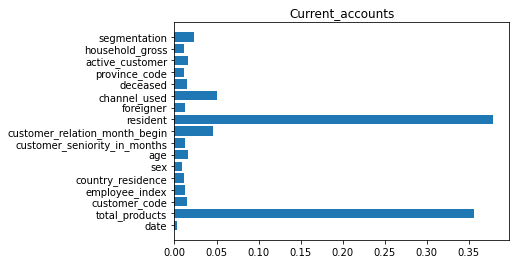

In [36]:
plt.title("Current_accounts")
plt.barh(range(len(feat_importances)), feat_importances)
plt.yticks(ticks=np.arange(0,len(xgb_X_columns)), labels=xgb_X_columns)
plt.show()
plt.close()

# Seems like high Max_depth and n_estimator has a big impact on the accuracy of the predictions. Therefore, will run all the y_targets with max_depth=17 and n_estimator=500, learning_rate=0.1

In [44]:
Y_columns[2]

'current_accounts'



1. saving_account target column : modeling and results

Classification Report for saving_account target : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1069884
           1       0.83      1.00      0.91        65

    accuracy                           1.00   1069949
   macro avg       0.92      1.00      0.95   1069949
weighted avg       1.00      1.00      1.00   1069949

Accuracy score for validation dataset : 1.0

Confusion matrix


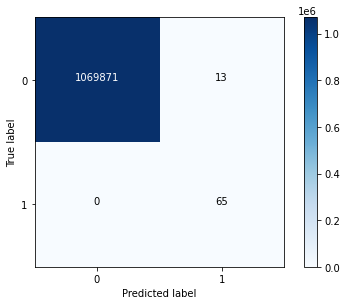

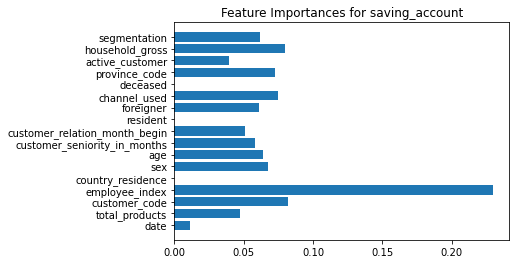



2. guarantees target column : modeling and results

Classification Report for guarantees target : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1069937
           1       0.71      1.00      0.83        12

    accuracy                           1.00   1069949
   macro avg       0.85      1.00      0.91   1069949
weighted avg       1.00      1.00      1.00   1069949

Accuracy score for validation dataset : 0.9999963362850663

Confusion matrix


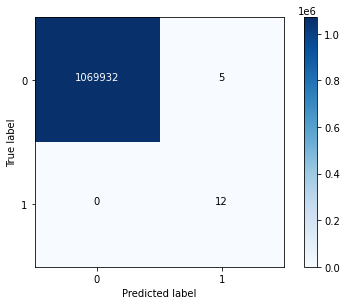

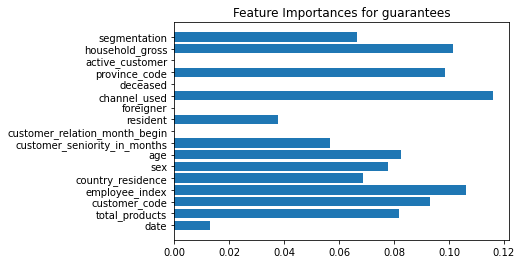



3. current_accounts target column : modeling and results

Classification Report for current_accounts target : 
              precision    recall  f1-score   support

           0       0.94      0.99      0.96    396977
           1       0.99      0.96      0.98    672972

    accuracy                           0.97   1069949
   macro avg       0.97      0.98      0.97   1069949
weighted avg       0.97      0.97      0.97   1069949

Accuracy score for validation dataset : 0.975412809080151

Confusion matrix


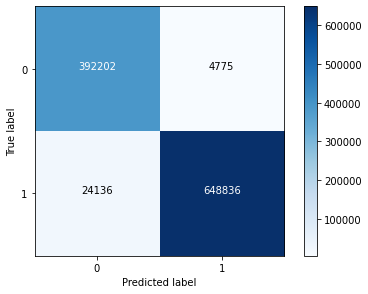

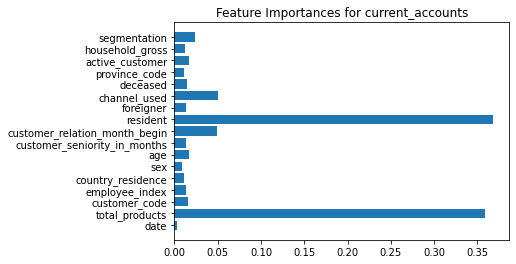



4. derivada_account target column : modeling and results

Classification Report for derivada_account target : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1069653
           1       0.91      0.99      0.95       296

    accuracy                           1.00   1069949
   macro avg       0.95      1.00      0.97   1069949
weighted avg       1.00      1.00      1.00   1069949

Accuracy score for validation dataset : 0.9999926725701327

Confusion matrix


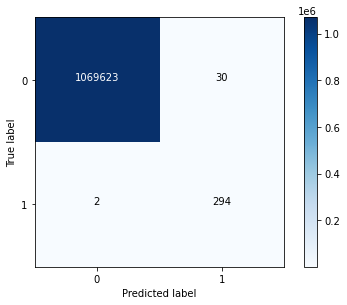

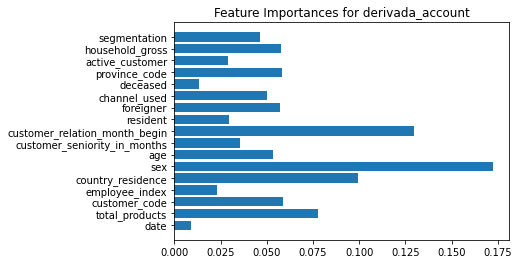



5. payroll_account target column : modeling and results

Classification Report for payroll_account target : 
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    999072
           1       0.85      0.96      0.90     70877

    accuracy                           0.99   1069949
   macro avg       0.92      0.98      0.95   1069949
weighted avg       0.99      0.99      0.99   1069949

Accuracy score for validation dataset : 0.9845904149889906

Confusion matrix


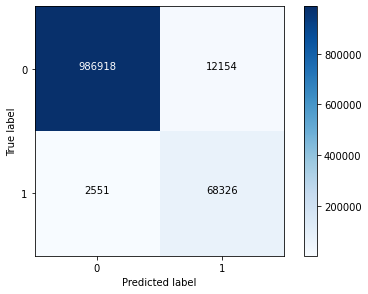

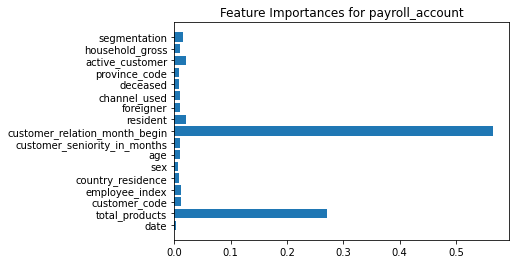



6. junior_account target column : modeling and results

Classification Report for junior_account target : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1061879
           1       1.00      1.00      1.00      8070

    accuracy                           1.00   1069949
   macro avg       1.00      1.00      1.00   1069949
weighted avg       1.00      1.00      1.00   1069949

Accuracy score for validation dataset : 1.0

Confusion matrix


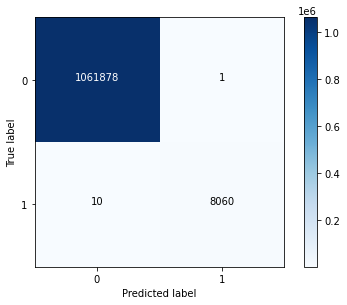

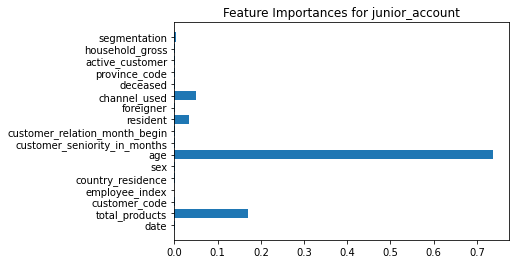



7. mas_particular_account target column : modeling and results

Classification Report for mas_particular_account target : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1059778
           1       0.82      0.92      0.87     10171

    accuracy                           1.00   1069949
   macro avg       0.91      0.96      0.93   1069949
weighted avg       1.00      1.00      1.00   1069949

Accuracy score for validation dataset : 0.9995347082034242

Confusion matrix


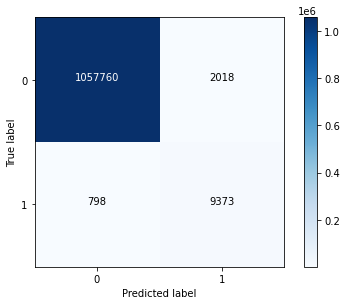

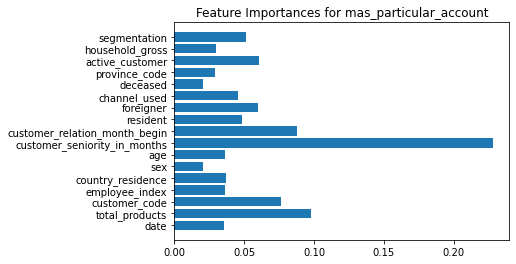



8. particular_account target column : modeling and results

Classification Report for particular_account target : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    969315
           1       0.97      0.96      0.97    100634

    accuracy                           0.99   1069949
   macro avg       0.98      0.98      0.98   1069949
weighted avg       0.99      0.99      0.99   1069949

Accuracy score for validation dataset : 1.0

Confusion matrix


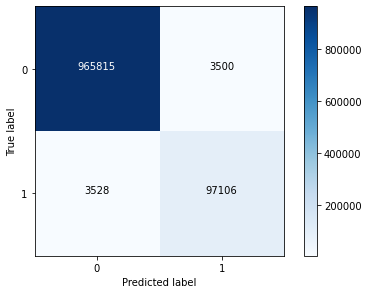

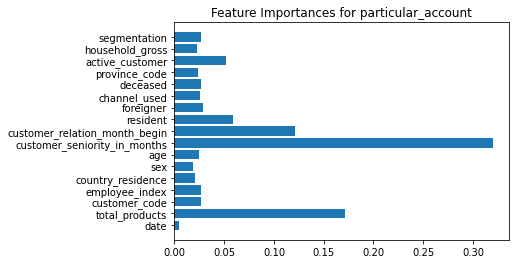



9. particular_plus_account target column : modeling and results

Classification Report for particular_plus_account target : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1039120
           1       0.91      0.98      0.95     30829

    accuracy                           1.00   1069949
   macro avg       0.96      0.99      0.97   1069949
weighted avg       1.00      1.00      1.00   1069949

Accuracy score for validation dataset : 1.0

Confusion matrix


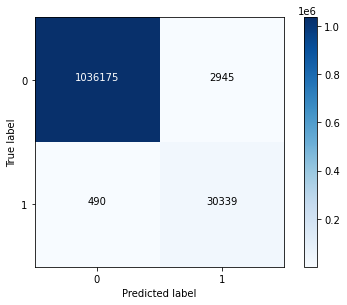

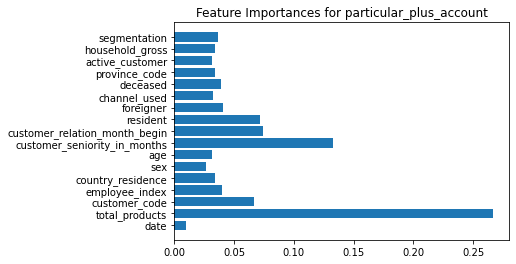



10. short_term_deposits target column : modeling and results

Classification Report for short_term_deposits target : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1069653
           1       0.92      0.98      0.95       296

    accuracy                           1.00   1069949
   macro avg       0.96      0.99      0.97   1069949
weighted avg       1.00      1.00      1.00   1069949

Accuracy score for validation dataset : 1.0

Confusion matrix


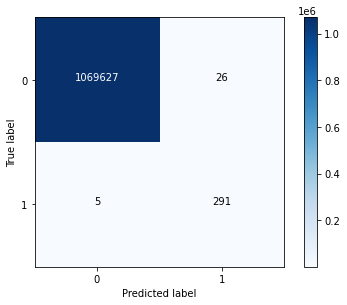

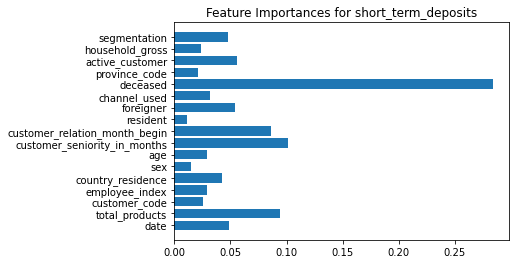



11. medium_term_deposits target column : modeling and results

Classification Report for medium_term_deposits target : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1068965
           1       0.94      0.99      0.96       984

    accuracy                           1.00   1069949
   macro avg       0.97      0.99      0.98   1069949
weighted avg       1.00      1.00      1.00   1069949

Accuracy score for validation dataset : 0.9999853451402654

Confusion matrix


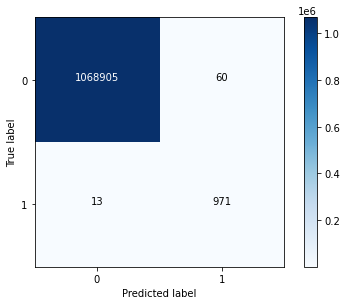

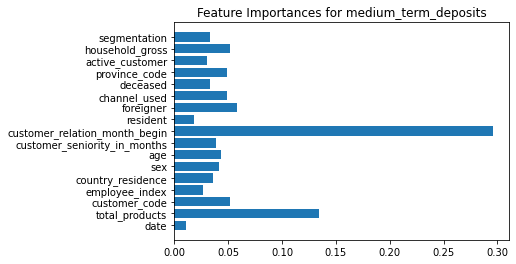



12. long_term_deposits target column : modeling and results

Classification Report for long_term_deposits target : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1038661
           1       0.89      0.96      0.93     31288

    accuracy                           1.00   1069949
   macro avg       0.95      0.98      0.96   1069949
weighted avg       1.00      1.00      1.00   1069949

Accuracy score for validation dataset : 0.9976515587275185

Confusion matrix


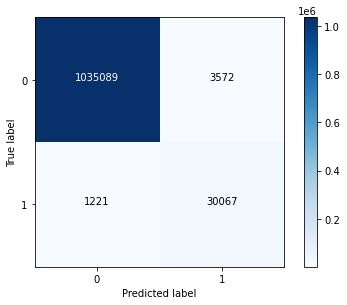

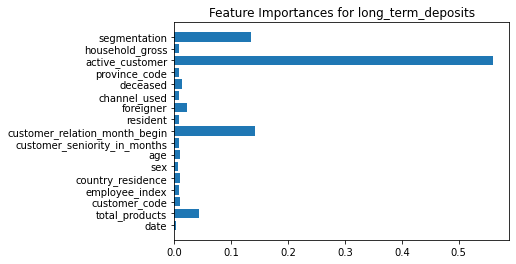



13. e_account target column : modeling and results

Classification Report for e_account target : 
              precision    recall  f1-score   support

           0       1.00      0.99      0.99   1001050
           1       0.84      0.98      0.90     68899

    accuracy                           0.99   1069949
   macro avg       0.92      0.98      0.95   1069949
weighted avg       0.99      0.99      0.99   1069949

Accuracy score for validation dataset : 0.9890418286333977

Confusion matrix


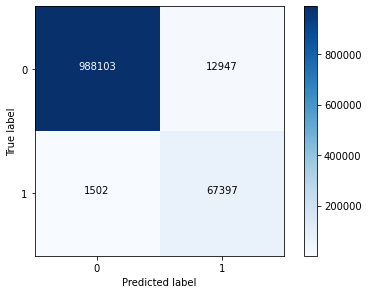

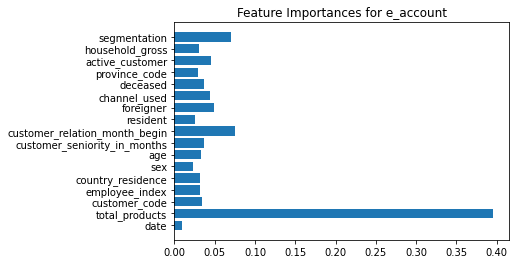



14. funds target column : modeling and results

Classification Report for funds target : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1056299
           1       0.90      0.99      0.94     13650

    accuracy                           1.00   1069949
   macro avg       0.95      0.99      0.97   1069949
weighted avg       1.00      1.00      1.00   1069949

Accuracy score for validation dataset : 0.9992599295833989

Confusion matrix


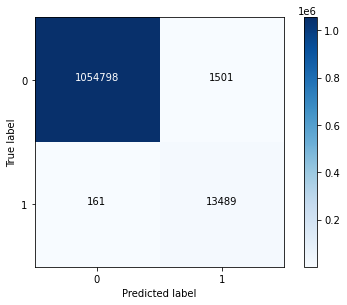

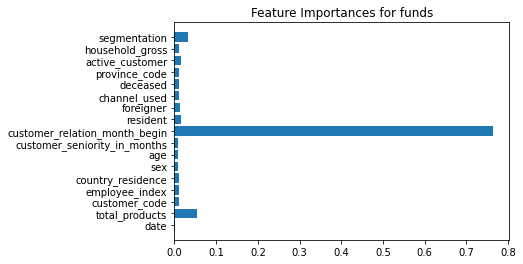



15. mortgage target column : modeling and results

Classification Report for mortgage target : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1065655
           1       0.94      0.99      0.97      4294

    accuracy                           1.00   1069949
   macro avg       0.97      1.00      0.98   1069949
weighted avg       1.00      1.00      1.00   1069949

Accuracy score for validation dataset : 0.999978017710398

Confusion matrix


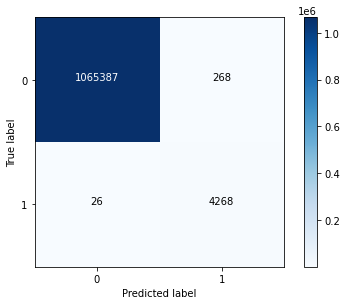

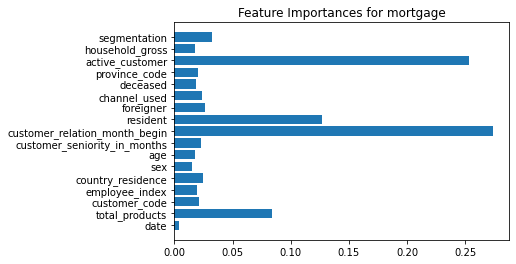



16. pensions_1 target column : modeling and results

Classification Report for pensions_1 target : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1063098
           1       0.92      0.99      0.95      6851

    accuracy                           1.00   1069949
   macro avg       0.96      1.00      0.98   1069949
weighted avg       1.00      1.00      1.00   1069949

Accuracy score for validation dataset : 0.9998131505383829

Confusion matrix


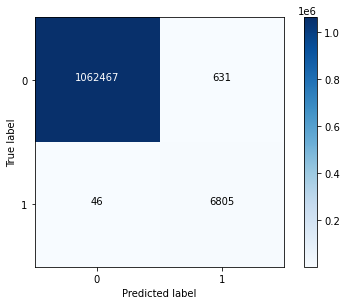

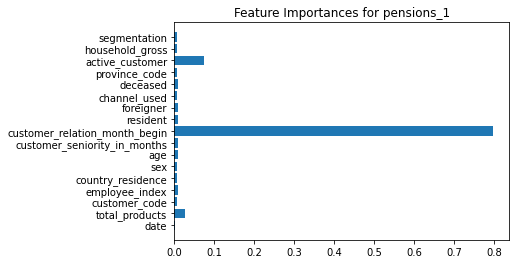



17. loans target column : modeling and results

Classification Report for loans target : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1068004
           1       0.97      0.99      0.98      1945

    accuracy                           1.00   1069949
   macro avg       0.98      1.00      0.99   1069949
weighted avg       1.00      1.00      1.00   1069949

Accuracy score for validation dataset : 0.999978017710398

Confusion matrix


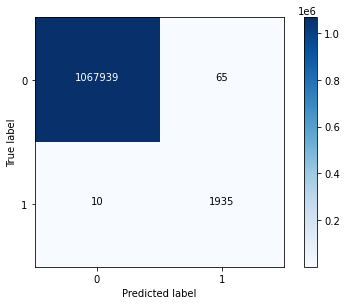

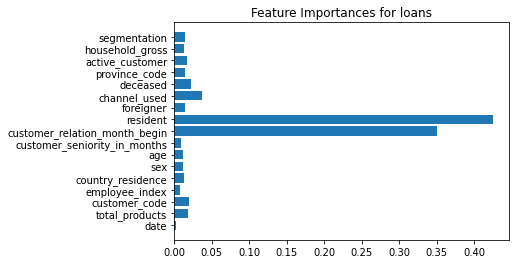



18. taxes target column : modeling and results

Classification Report for taxes target : 
              precision    recall  f1-score   support

           0       1.00      0.99      1.00   1027458
           1       0.88      0.99      0.93     42491

    accuracy                           0.99   1069949
   macro avg       0.94      0.99      0.96   1069949
weighted avg       0.99      0.99      0.99   1069949

Accuracy score for validation dataset : 0.995757418106812

Confusion matrix


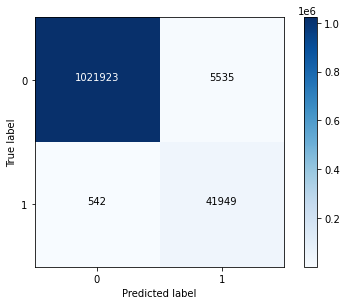

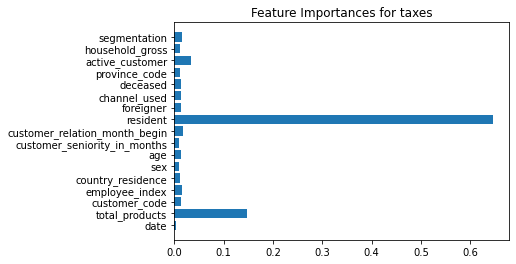



19. credit_card target column : modeling and results

Classification Report for credit_card target : 
              precision    recall  f1-score   support

           0       1.00      0.99      1.00   1038236
           1       0.85      0.96      0.90     31713

    accuracy                           0.99   1069949
   macro avg       0.92      0.98      0.95   1069949
weighted avg       0.99      0.99      0.99   1069949

Accuracy score for validation dataset : 0.9962410284780562

Confusion matrix


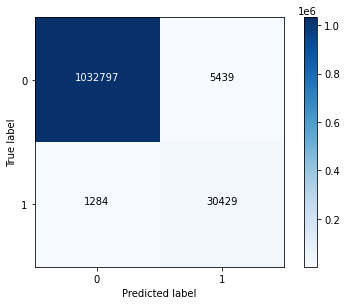

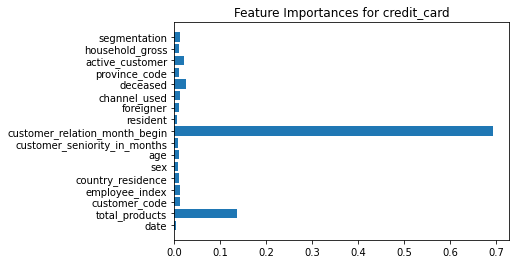



20. securities target column : modeling and results

Classification Report for securities target : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1049992
           1       0.90      0.99      0.94     19957

    accuracy                           1.00   1069949
   macro avg       0.95      0.99      0.97   1069949
weighted avg       1.00      1.00      1.00   1069949

Accuracy score for validation dataset : 0.9992306198639296

Confusion matrix


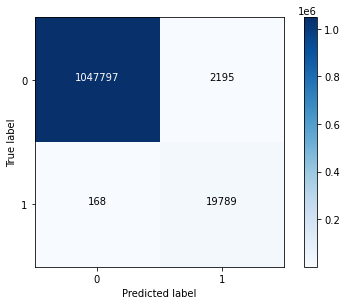

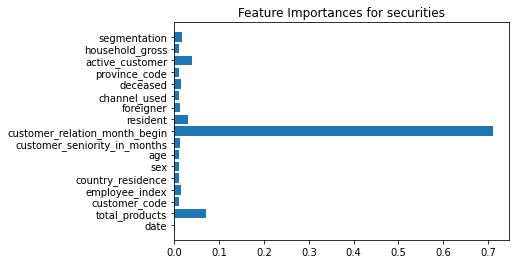



21. home_account target column : modeling and results

Classification Report for home_account target : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1067214
           1       0.92      0.99      0.95      2735

    accuracy                           1.00   1069949
   macro avg       0.96      1.00      0.98   1069949
weighted avg       1.00      1.00      1.00   1069949

Accuracy score for validation dataset : 1.0

Confusion matrix


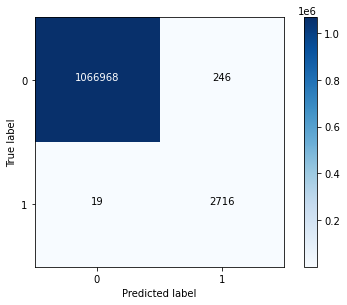

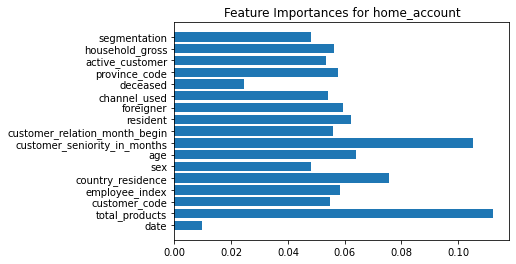



22. payroll target column : modeling and results

Classification Report for payroll target : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1018022
           1       0.97      0.97      0.97     51927

    accuracy                           1.00   1069949
   macro avg       0.98      0.98      0.98   1069949
weighted avg       1.00      1.00      1.00   1069949

Accuracy score for validation dataset : 0.9976039304333808

Confusion matrix


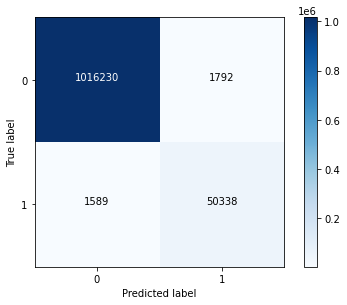

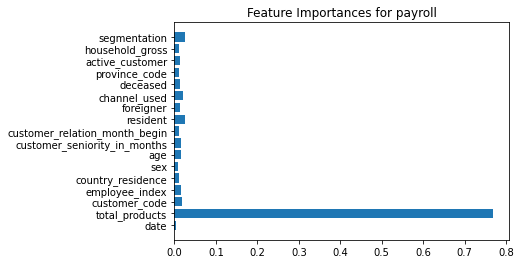



23. pensions_2 target column : modeling and results

Classification Report for pensions_2 target : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1013293
           1       0.97      0.97      0.97     56656

    accuracy                           1.00   1069949
   macro avg       0.98      0.98      0.98   1069949
weighted avg       1.00      1.00      1.00   1069949

Accuracy score for validation dataset : 0.9973071695237536

Confusion matrix


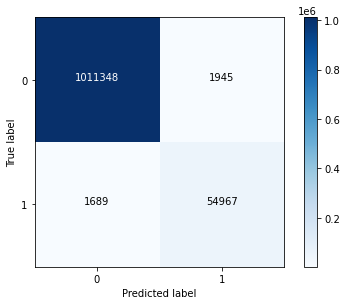

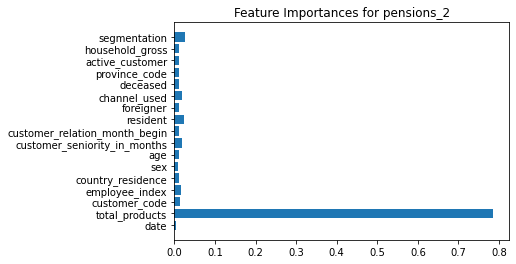



24. direct_debit target column : modeling and results

Classification Report for direct_debit target : 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    944478
           1       0.94      0.95      0.94    125471

    accuracy                           0.99   1069949
   macro avg       0.97      0.97      0.97   1069949
weighted avg       0.99      0.99      0.99   1069949

Accuracy score for validation dataset : 0.9893678992624941

Confusion matrix


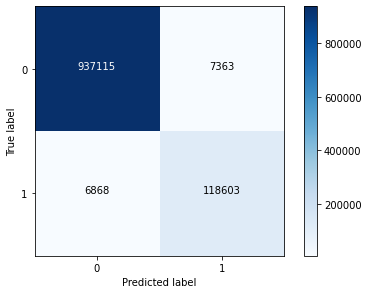

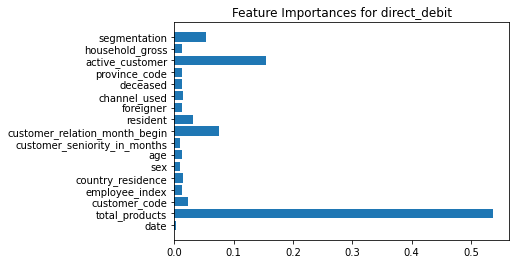

In [59]:
for i in range(y_test.shape[1]):
    print("\n\n{}. {} target column : modeling and results".format(i+1, Y_columns[i]))
    xgb_model = xgb.XGBClassifier(tree_method='gpu_hist', gpu_id=0, learning_rate=0.1, max_depth=17, n_estimators=500)
    xgb_model.fit(X_train, y_train[:,i])

    y_pred = xgb_model.predict(X_test)
    print("\nClassification Report for {} target : \n{}".format(Y_columns[i],classification_report(y_pred, y_test[:,i])))

    y_valid_pred = xgb_model.predict(X_valid)
    print("Accuracy score for validation dataset : {}".format(accuracy_score(y_valid_pred, y_valid[:,i])))

    print("\nConfusion matrix")
    conf_matrix = confusion_matrix(y_pred, y_test[:,i])
    plt.imshow(conf_matrix, cmap=plt.cm.Blues, interpolation='nearest')
    tick_marks = np.arange(2)   
    classes = ["0","1"]
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    thresho = conf_matrix.max() / 2.
    # The below for loop helps to add numbers in the boxes
    for k, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
        plt.text(j, k, conf_matrix[k, j], horizontalalignment="center", color="white" if conf_matrix[k, j] > thresho else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.colorbar()
    plt.show()
    plt.close()

    feat_importances = xgb_model.feature_importances_
    plt.title("Feature Importances for {}".format(Y_columns[i]))
    plt.barh(range(len(feat_importances)), feat_importances)
    plt.yticks(ticks=np.arange(0,len(xgb_X_columns)), labels=xgb_X_columns)
    plt.show()
    plt.close()
    
    del xgb_model
    del y_pred
    del y_valid_pred